## Introduction

The repeated measures ANOVA makes the following assumptions about the
data:

-   **No significant outliers** in any cell of the design.

-   **Normality**: the outcome (or dependent) variable should be
    approximately normally distributed in each cell of the design. This
    can be checked using the **Shapiro-Wilk normality test** or by visual inspection using **QQ
    plot**.

-   **Assumption of sphericity**: the variance of the differences
    between groups should be equal. This can be checked using the
    **Mauchly's test of sphericity**.

Note that, [**if the above assumptions are not met**]{.underline} there
are a non-parametric alternative (*Friedman test*) to the one-way
repeated measures ANOVA!

Unfortunately, there are no non-parametric alternatives to three-way repeated measures ANOVA. Thus, in the situation where the assumptions are not met, you could consider running the
two-way/three-way repeated measures ANOVA on the transformed and
non-transformed data to see if there are any meaningful differences.

If both tests lead you to the same conclusions, you might not choose to
transform the outcome variable and carry on with the two-way/three-way
repeated measures ANOVA on the original data.

It's also possible to perform robust ANOVA test.

No matter your choice, you should report what you did in your results.

## RM Anova in Python

Key Python functions:

### statsmodels

AnovaRM: This function is part of the statsmodels library and is used for conducting repeated-measures ANOVA.

from statsmodels.stats.anova import AnovaRM

Usage:

anova = AnovaRM(data, 'dependent_variable', 'subject', within=['within_factor'])

result = anova.fit()

print(result)

### pingouin:

rm_anova: This function is part of the pingouin library and is also used for conducting repeated-measures ANOVA.

result = pg.rm_anova(dv='dependent_variable', within='within_factor', subject='subject', data=data)

print(result)

## 1-way RM Anova

The dataset "***selfesteem***" contains 10 individuals' self-esteem
score on three time points during a specific diet to determine whether
their self-esteem improved.



In [1]:
import pandas as pd

# URL to the CSV file
url = "https://github.com/kflisikowski/ds/raw/master/selfesteem.csv"

# Load the data into a DataFrame
selfesteem = pd.read_csv(url)

# Display the first few rows of the data
print(selfesteem.head())

   id        t1        t2        t3
0   1  4.005027  5.182286  7.107831
1   2  2.558124  6.912915  6.308434
2   3  3.244241  4.443434  9.778410
3   4  3.419538  4.711696  8.347124
4   5  2.871243  3.908429  6.457287


The one-way repeated measures ANOVA can be used to determine whether the
means self-esteem scores are significantly different between the three
time points. So let's convert this data frame into long format:

In [2]:
# Transform the data
selfesteem = selfesteem.melt(id_vars=['id'], value_vars=['t1', 't2', 't3'],
                             var_name='time', value_name='score')

# Convert 'id' and 'time' columns to categorical
selfesteem['id'] = selfesteem['id'].astype('category')
selfesteem['time'] = selfesteem['time'].astype('category')

# Display the first 3 rows of the transformed data
print(selfesteem.head(3))

  id time     score
0  1   t1  4.005027
1  2   t1  2.558124
2  3   t1  3.244241


### Descriptive statistics

In [3]:
# Group by 'time' and calculate mean and standard deviation for 'score'
summary_stats = selfesteem.groupby('time')['score'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.columns = ['time', 'mean_score', 'sd_score']

# Display the summary statistics
print(summary_stats)

  time  mean_score  sd_score
0   t1    3.140122  0.551806
1   t2    4.933942  0.863070
2   t3    7.636342  1.142598


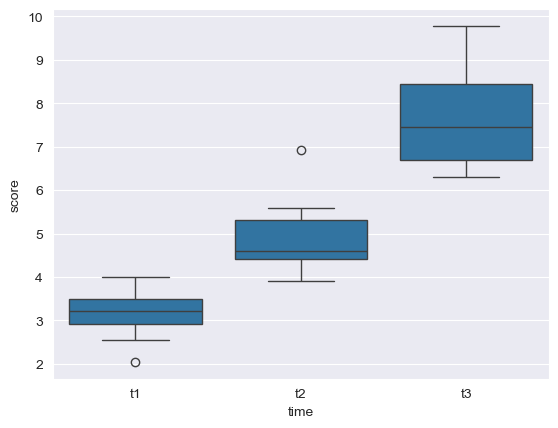

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
bxp = sns.boxplot(x='time', y='score', data=selfesteem)

# Display the plot
plt.show()

### Assumptions

Identify outliers in each cell design:

In [5]:
# Function to identify outliers using IQR method
def identify_outliers(group):
    Q1 = group['score'].quantile(0.25)
    Q3 = group['score'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (group['score'] < (Q1 - 1.5 * IQR)) | (group['score'] > (Q3 + 1.5 * IQR))
    return group[outliers]


# Identify outliers
outliers = selfesteem.groupby('time').apply(identify_outliers).reset_index(drop=True)

# Display the outliers
print(outliers)

  id time     score
0  6   t1  2.045868
1  2   t2  6.912915


Check normality assumption by analyzing the model residuals. QQ plot and
Shapiro-Wilk test of normality are used.

In [7]:
import pingouin as pg

# Perform Shapiro-Wilk test for normality
shapiro_results = selfesteem.groupby('time').apply(lambda x: pg.normality(x['score'], method='shapiro'))

# Display the results
print(shapiro_results)

                   W      pval  normal
time                                  
t1   score  0.966690  0.858576    True
t2   score  0.875885  0.116996    True
t3   score  0.922715  0.380157    True


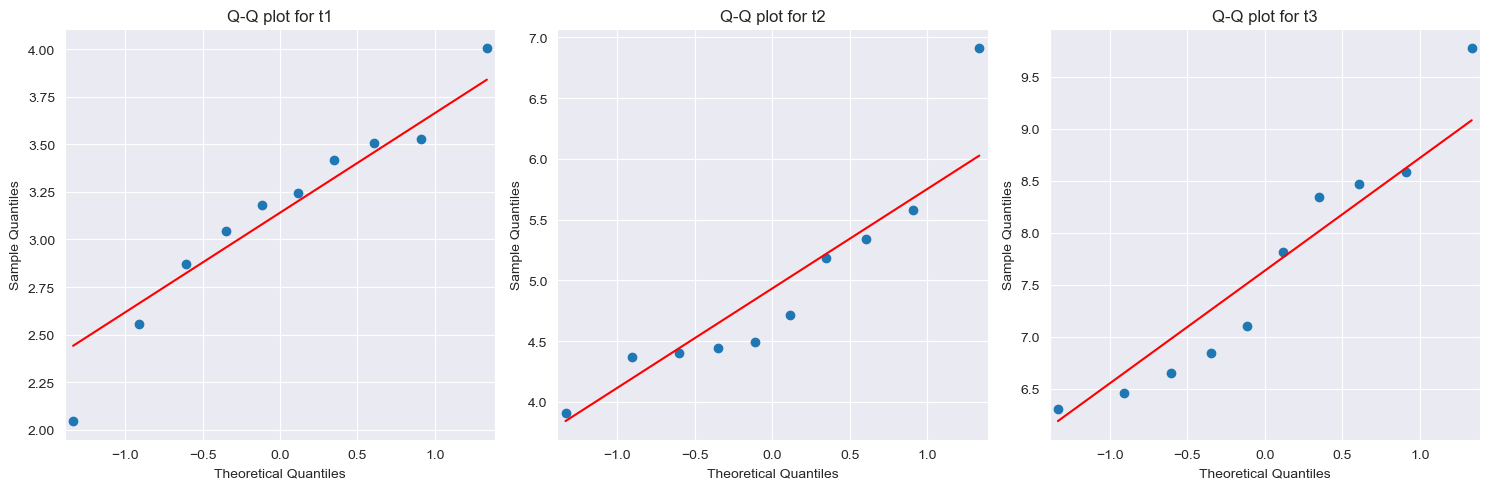

In [8]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create Q-Q plots for each time group
time_groups = selfesteem['time'].unique()
fig, axes = plt.subplots(1, len(time_groups), figsize=(15, 5))

for i, time in enumerate(time_groups):
    sm.qqplot(selfesteem[selfesteem['time'] == time]['score'], line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {time}')

plt.tight_layout()
plt.show()

### Anova

In [9]:
import pingouin as pg

# Perform repeated-measures ANOVA
results = pg.rm_anova(data=selfesteem, dv='score', detailed=True, within='time', subject='id')

# Display the results
results.round(3)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,102.456,2,51.228,55.469,0.0,0.829,0.69
1,Error,16.624,18,0.924,NaN,NaN,NaN,NaN


## How to interpret R-M Anova results?

Source: The source of variance. In this case, it is time, indicating that we are analyzing the effect of time on the score variable.

ddof1: Degrees of freedom for the time factor (df_between). In this case, it is 2 because we have three measurements (t1, t2, t3), so df_between = number of levels - 1.

ddof2: Degrees of freedom for the error (df_within). In this case, it is 18, which results from the number of participants multiplied by (number of levels - 1).

F: The F-statistic. This value tells us how large the difference between groups is compared to the differences within groups. A higher F value suggests a larger difference between groups.

p-unc: The p-value (uncorrected). This value tells us whether the differences between groups are statistically significant. A p-value < 0.05 suggests that the differences are statistically significant.

np2: Eta-squared (η²), a measure of effect size. This value tells us how much of the variance in the data is explained by the time factor. Eta-squared values can be interpreted as:

0.01: small effect

0.06: medium effect

0.14: large effect

'eps': Greenhouse-Geisser epsilon factor (= index of sphericity) - The repeated measures ANOVA table is very similar to the one-way ANOVA table, with an additional eps column. This refers to the epsilon statistic, which indicates the degree to which sphericity is present or not. An epsilon of 1 means that the condition of sphericity is exactly met. The further epsilon decreases below 1, the greater the violation of sphericity.

If the sphericity assumption is not met, Pingouin returns the Mauchly test chi-square statistic and p-values, as well as the Greenhouse-Geisser corrected p-value of the ANOVA (The Greenhouse-Geisser correction uses epsilon to correct the degrees of freedom of the ANOVA). You can force the correction using correction=True.

## Interpretation:

The results of the repeated-measures ANOVA show that time (time) ...

### Post-hoc tests

In [11]:
# Perform pairwise comparisons with Bonferroni correction
pwc = pg.pairwise_tests(dv='score', within='time', subject='id', data=selfesteem, padjust='bonferroni')

# Display the results
print(pwc)

  Contrast   A   B  Paired  Parametric          T  dof alternative  \
0     time  t1  t2    True        True  -4.967618  9.0   two-sided   
1     time  t1  t3    True        True -13.228148  9.0   two-sided   
2     time  t2  t3    True        True  -4.867816  9.0   two-sided   

          p-unc    p-corr    p-adjust      BF10    hedges  
0  7.724196e-04  0.002317  bonferroni    50.694 -2.371801  
1  3.343804e-07  0.000001  bonferroni  4.02e+04 -4.799517  
2  8.861912e-04  0.002659  bonferroni    45.195 -2.556194  


AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

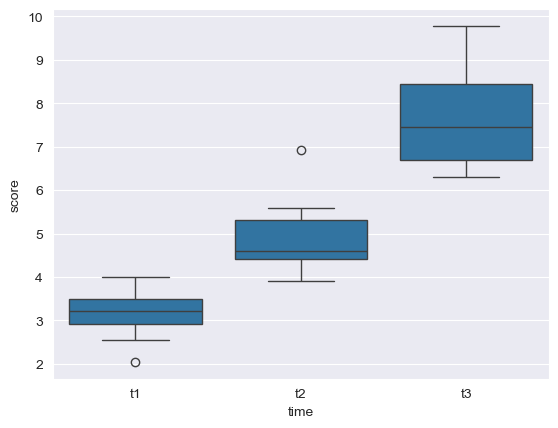

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statannotations.Annotator import Annotator

# Create the boxplot
bxp = sns.boxplot(x='time', y='score', data=selfesteem)

# Add pairwise comparison results to the plot
pairs = [(a, b) for a, b in zip(pwc['A'], pwc['B'])]
annotator = Annotator(bxp, pairs, data=selfesteem, x='time', y='score')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()

# Add labels
plt.title('Boxplot with Pairwise Comparisons')
plt.suptitle(pg.rm_anova(data=selfesteem, dv='score', within='time', subject='id').to_string(), y=0.95)
plt.figtext(0.5, -0.05, pwc.to_string(), wrap=True, horizontalalignment='center', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

Hence, we can conclude that the score was statistically significantly
different during different times, with the result with F(2,18) = 55.5
and p = 0.0000000201. From the post-hoc tests, when pairwise comparisons
were conducted we can state that all the differences between pairs are
statistically significant.


## 1-way RM Anova [DIY]

Researchers want to know if four different drugs lead to different
reaction times. To test this, they measure the reaction time of 5
patients on the four different drugs. Since each patient is measured on
each of the four drugs, we must use the R-M Anova.

Dataset:

In [12]:
import pandas as pd

# Create the DataFrame
mydata = pd.DataFrame({
    'patient': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
    'drug': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
    'response': [30, 28, 16, 34, 14, 18, 10, 22, 24, 20, 18, 30, 38, 34, 20, 44, 26, 28, 14, 30]
})

# Display the DataFrame
print(mydata)

    patient  drug  response
0         1     1        30
1         1     2        28
2         1     3        16
3         1     4        34
4         2     1        14
5         2     2        18
6         2     3        10
7         2     4        22
8         3     1        24
9         3     2        20
10        3     3        18
11        3     4        30
12        4     1        38
13        4     2        34
14        4     3        20
15        4     4        44
16        5     1        26
17        5     2        28
18        5     3        14
19        5     4        30


In [21]:
results = pg.rm_anova(data=mydata, dv='response', detailed=True, within='drug', subject='patient')
results.round(3)

pwc = pg.pairwise_tests(dv='response', within='drug', subject='patient', data=mydata, padjust='bonf')
print(pwc)

  Contrast  A  B  Paired  Parametric         T  dof alternative     p-unc  \
0     drug  1  2    True        True  0.492366  4.0   two-sided  0.648261   
1     drug  1  3    True        True  4.191213  4.0   two-sided  0.013793   
2     drug  1  4    True        True -7.483315  4.0   two-sided  0.001705   
3     drug  2  3    True        True  4.385290  4.0   two-sided  0.011826   
4     drug  2  4    True        True -4.000000  4.0   two-sided  0.016130   
5     drug  3  4    True        True -7.363817  4.0   two-sided  0.001812   

     p-corr p-adjust    BF10    hedges  
0  1.000000     bonf   0.439  0.093441  
1  0.082758     bonf   5.588  1.441409  
2  0.010231     bonf  25.477 -0.602834  
3  0.070956     bonf   6.244  1.683062  
4  0.096781     bonf   4.992 -0.791053  
5  0.010872     bonf  24.372 -2.359892  



## 3-way R-M Anova (homework)

We'll use the weightloss dataset [datarium package]. 

In this study, a researcher wanted to assess the effects of Diet and Exercises on weight loss in 10 sedentary individuals.

The participants were enrolled in four trials: (1) no diet and no exercises; (2) diet only; (3) exercises only; and (4) diet and exercises combined.

Each participant performed all four trials. 

The order of the trials was counterbalanced and sufficient time was allowed between trials to allow any effects of previous trials to have dissipated.

Each trial lasted nine weeks and the weight loss score was measured at the beginning (t1), at the midpoint (t2) and at the end (t3) of each trial.

In [3]:
import pandas as pd

# URL to the CSV file
url = "https://github.com/kflisikowski/ds/raw/master/weightloss.csv"

# Read the data into DataFrame
weightloss = pd.read_csv(url)

weightloss

,id,diet,exercises,t1,t2,t3
0,1,no,no,10.43,13.21,11.59
1,2,no,no,11.59,10.66,13.21
2,3,no,no,11.35,11.12,11.35
3,4,no,no,11.12,9.50,11.12
4,5,no,no,9.50,9.73,12.28
5,6,no,no,9.50,12.74,10.43
6,7,no,no,11.12,12.51,11.59
7,8,no,no,12.51,12.28,12.74
8,9,no,no,11.35,11.59,9.96
9,10,no,no,11.12,10.66,11.35


In [4]:
# Transform the data into long format
weightloss_long = weightloss.melt(id_vars=['id', 'diet', 'exercises'], value_vars=['t1', 't2', 't3'],
                                  var_name='time', value_name='score')

# Convert 'id' and 'time' columns to categorical types
weightloss_long['id'] = weightloss_long['id'].astype('category')
weightloss_long['time'] = weightloss_long['time'].astype('category')

# Inspect some random rows of the data by groups
sampled_data = weightloss_long.groupby(['diet', 'exercises', 'time']).sample(n=1, random_state=123)

# Display the results
print(sampled_data)

     id diet exercises time  score
5     6   no        no   t1   9.50
54    7   no        no   t2  12.51
102   7   no        no   t3  11.59
20    9   no       yes   t1  11.35
67    8   no       yes   t2  14.37
117  10   no       yes   t3  17.38
30    7  yes        no   t1  11.59
79    8  yes        no   t2  11.35
124   5  yes        no   t3  13.90
41    6  yes       yes   t1  10.66
93   10  yes       yes   t2  14.13
136   5  yes       yes   t3  15.29


In this example, the effect of the "time" is our focal variable, that is our primary concern.

It is thought that the effect of "time" on the weight loss score will depend on two other factors, "diet" and "exercises", which are called moderator variables.

In [6]:

from statsmodels.stats.anova import AnovaRM

rm_anova = AnovaRM(
    data=weightloss_long,
    depvar='score',
    subject='id',
    within=['time', 'diet', 'exercises'],
)

results = rm_anova.fit()

# Print the results
print(results)

                      Anova
                    F Value  Num DF  Den DF Pr > F
--------------------------------------------------
time                110.9416 2.0000 22.0000 0.0000
diet                  6.0214 1.0000 11.0000 0.0320
exercises            58.9281 1.0000 11.0000 0.0000
time:diet             0.6026 2.0000 22.0000 0.5562
time:exercises       20.8259 2.0000 22.0000 0.0000
diet:exercises       75.3561 1.0000 11.0000 0.0000
time:diet:exercises  14.2461 2.0000 22.0000 0.0001



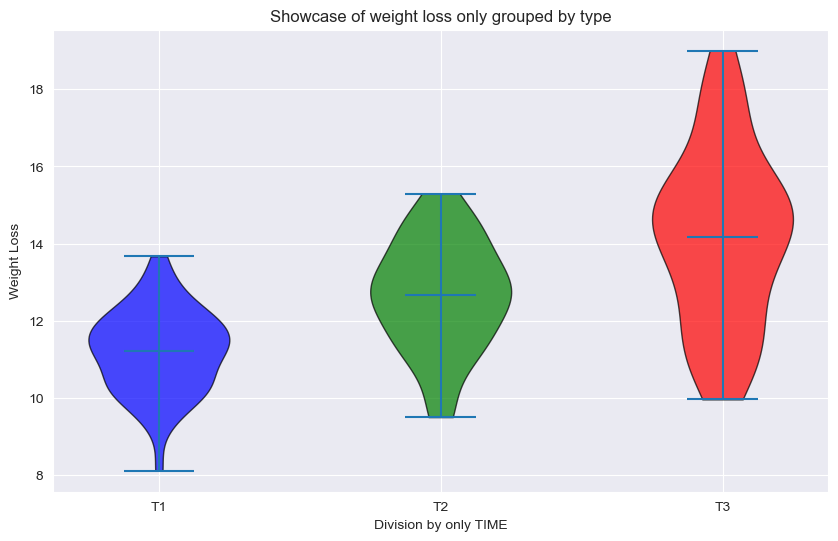

In [24]:
import matplotlib.pyplot as plt

# Create a violin plot
plt.figure(figsize=(10, 6))
violin_parts = plt.violinplot(weightloss[['t1', 't2', 't3']], showmeans=True, showextrema=True)

# Customize the plot
plt.title("Showcase of weight loss only grouped by type")
plt.xlabel("Division by only TIME")
plt.ylabel("Weight Loss")
plt.xticks([1, 2, 3], ['T1', 'T2', 'T3'])  # Group labels

# Add colors to each violin for better visualization
colors = ['blue', 'green', 'red']
for idx, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[idx])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Show the plot
plt.show()


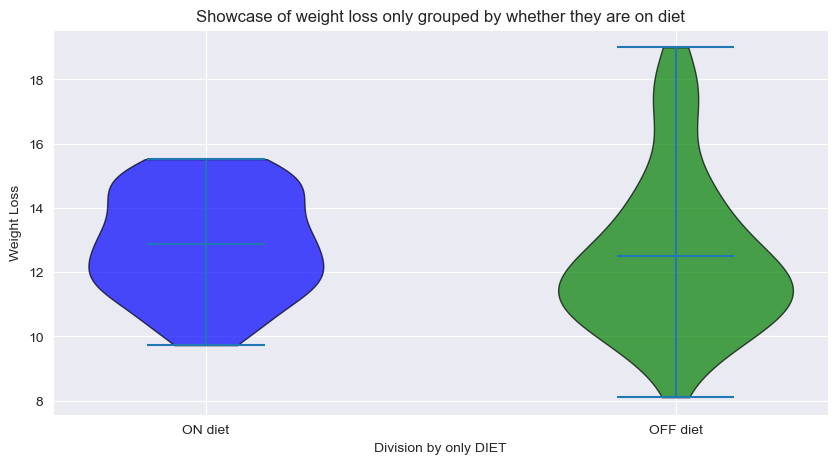

In [56]:

# Create a violin plot
plt.figure(figsize=(10, 5))
violin_parts = plt.violinplot(pd.DataFrame({'yes': weightloss_long[weightloss_long['diet'] == 'yes']['score'].values,
                                            'no': weightloss_long[weightloss_long['diet'] == 'no']['score'].values})
                              , showmeans=True, showextrema=True)

# Customize the plot
plt.title("Showcase of weight loss only grouped by whether they are on diet")
plt.xlabel("Division by only DIET")
plt.ylabel("Weight Loss")
plt.xticks([1, 2], ['ON diet', 'OFF diet'])  # Group labels

# Add colors to each violin for better visualization
colors = ['blue', 'green']
for idx, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[idx])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Show the plot
plt.show()

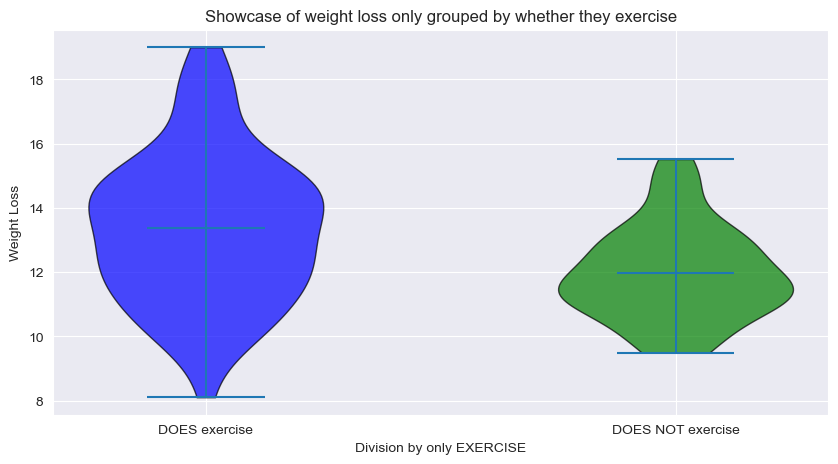

In [59]:

# Create a violin plot
plt.figure(figsize=(10, 5))
violin_parts = plt.violinplot(pd.DataFrame({'yes': weightloss_long[weightloss_long['exercises'] == 'yes']['score'].values,
                                            'no': weightloss_long[weightloss_long['exercises'] == 'no']['score'].values})
                              , showmeans=True, showextrema=True)

# Customize the plot
plt.title("Showcase of weight loss only grouped by whether they exercise")
plt.xlabel("Division by only EXERCISE")
plt.ylabel("Weight Loss")
plt.xticks([1, 2], ['DOES exercise', 'DOES NOT exercise'])  # Group labels

# Add colors to each violin for better visualization
colors = ['blue', 'green']
for idx, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[idx])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Show the plot
plt.show()

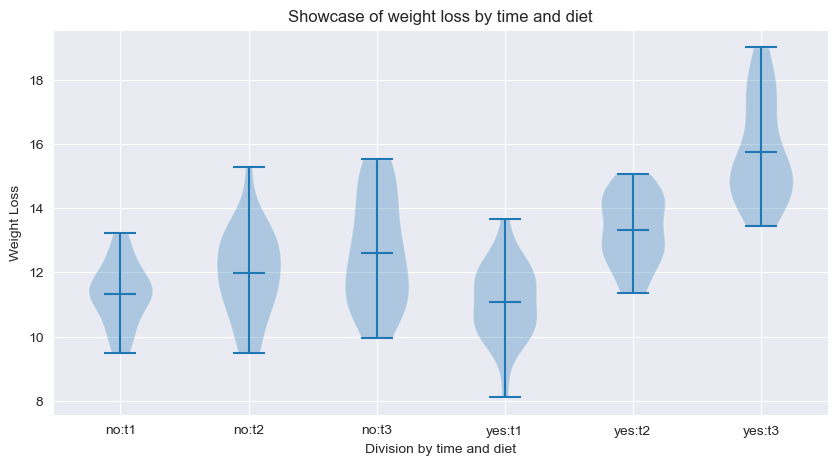

In [74]:
wide_df = weightloss_long.groupby(['exercises', 'time'])['score'].apply(list).apply(pd.Series).T


# Create a violin plot
plt.figure(figsize=(10, 5))
violin_parts = plt.violinplot(wide_df, showmeans=True, showextrema=True)

# Customize the plot
plt.title("Showcase of weight loss by time and diet")
plt.xlabel("Division by time and diet")
plt.ylabel("Weight Loss")
plt.xticks([1, 2, 3, 4, 5, 6], [':'.join(s) for s in wide_df.columns])  # Group labels

# Show the plot
plt.show()